# Quantum Routines


The ``QRoutine`` object allows for the convenient creation of sub programs (akin to a re-useable sequence of gates) within a quantum program:

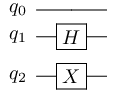

In [1]:
from qat.lang.AQASM import Program, QRoutine, X, H

# Creates a quantum routine consisting of a H gate on the first qubit, and a X gate on the second qubit
subprog = QRoutine()
subprog.apply(H, 0)
subprog.apply(X, 1)

# Now, create a program and apply the quantum routine to the qubit register
prog = Program()
qbits = prog.qalloc(3)
prog.apply(subprog, qbits[1:3])

circ = prog.to_circ()
%qatdisplay circ

``QRoutine``'s behave similarly to quantum gates. As a consequence, one can compose them:

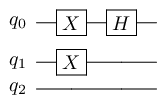

In [21]:
subprog2 = QRoutine()
subprog2.apply(X, 0)
subprog2.apply(subprog, 0, 1)

prog2 = Program()
qbits = prog2.qalloc(3)
prog2.apply(subprog2, qbits[0:2])

circ2 = prog2.to_circ()
%qatdisplay circ2

One can also apply the gate operators (ctrl, conj, dag etc.) to quantum routines, e.g:

In [22]:
conjsub = subprog.conj()
prog.apply(conjsub, qbits[0:2])

## More complex scenario

`QRoutine` allow us to create more complex gates. The `build_gate` decorator allows you to turn any Python function returning a `QRoutine` into an `AbstractGate`.

As an example, let's implement a generic Walsh-Hadamard gate acting on a variable number of qubits.

In [46]:
from qat.lang.AQASM import *

@build_gate("MyWalshHadamard", [int])
def constant_zero_oracle(nqubits):
    qrout = QRoutine()
    qreg = qrout.new_wires(nqubits)
    for qb in qreg:
        qrout.apply(H, qb)
    return qrout

Note that, with this definition, we cannot display the `QRoutine` as it is now. 

In [47]:
wh3 = constant_zero_oracle(3)
try:
    %qatdisplay wh3
except:
    import traceback
    traceback.print_exc(limit=1)

Traceback (most recent call last):
  File "/tmp/ipykernel_157994/1103771466.py", line 3, in <cell line: 2>
    get_ipython().run_line_magic('qatdisplay', 'wh3')
TypeError: 'NoneType' object cannot be interpreted as an integer


The main problem is that there is no static check on the arity of this routine, meaning something like this is totally fine.

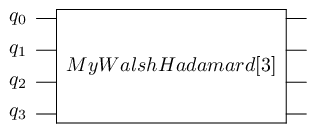

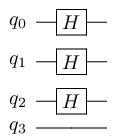

In [35]:
pr = Program()
qr = pr.qalloc(4)

# we applied a gate defined for 3 qubits on a quantum register of 4 qubits
pr.apply(wh3, qr)

cr = pr.to_circ()
%qatdisplay cr
%qatdisplay cr --depth=1

In order to display the `QRoutine` and, most importantly, have a static check on the its application, we can define a function generate its arity based on the number of qubits it has.

In [36]:
@build_gate("MyWalshHadamard", [int], arity=lambda n:n)
def constant_zero_oracle(nqubits):
    qrout = QRoutine()
    qreg = qrout.new_wires(nqubits)
    for qb in qreg:
        qrout.apply(H, qb)
    return qrout

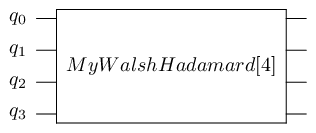

In [37]:
wh4 = constant_zero_oracle(4)
%qatdisplay wh4

Note how, if we apply the gate to a quantum register with 5 qubits, the `apply` will raise an exception.

In [43]:
pr = Program()
qr = pr.qalloc(5)

try:
    pr.apply(wh4, qr)
except:
    import traceback
    traceback.print_exc(limit=1)

Traceback (most recent call last):
  File "/tmp/ipykernel_157994/3276928.py", line 6, in <cell line: 5>
    pr.apply(wh4, qr)
qat.lang.AQASM.aqasm_util.InvalidGateArguments: Gate MyWalshHadamard of arity 4 cannot be applied on [q[0],q[1],q[2],q[3],q[4]]


But we can safely apply the gate to a quantum register of right size.

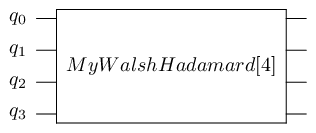

In [44]:
pr = Program()
qr = pr.qalloc(4)

pr.apply(wh4, qr)

cr = pr.to_circ()
%qatdisplay cr

## Replace gate set

[here](../../tutorials/lang/very_advanced_linker.ipynb) a more complex example on how to exploits `QRoutine` to convert a gate from one gate set to another.